In [44]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import pywt
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares
from scipy.signal import spectrogram

In [45]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [46]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

![Screenshot 2023-11-03 at 1.12.06 PM.png](<attachment:Screenshot 2023-11-03 at 1.12.06 PM.png>)
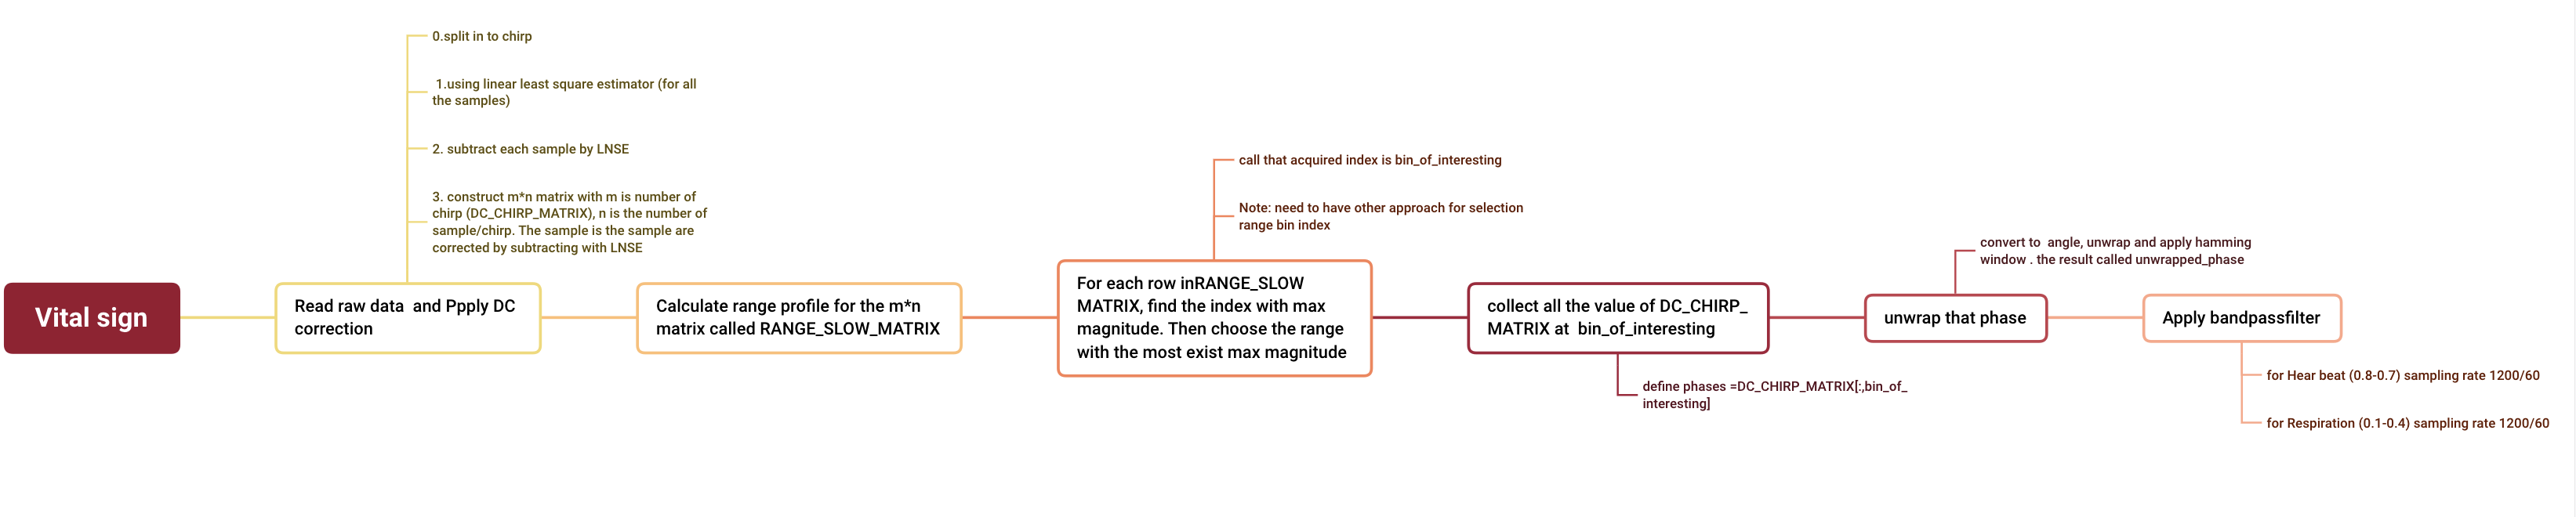

In [47]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


In [48]:
def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.5,0.5,0.5])
real_parts = []
imag_parts = []
IFchirps = np.array(first_chirps_of_frame).flatten()
for IFchirp in IFchirps:
    real_parts.append(IFchirp.real)
    imag_parts.append(IFchirp.imag)
r_result = least_squares(residuals, initial_params, args=(np.array(real_parts).flatten(), (np.array(imag_parts).flatten())))


In [49]:
a,b,c =r_result.x
DC_compensation =a+b*1j 
DC_corrected_chirps = [ (first_chirp -DC_compensation) for first_chirp in first_chirps_of_frame]

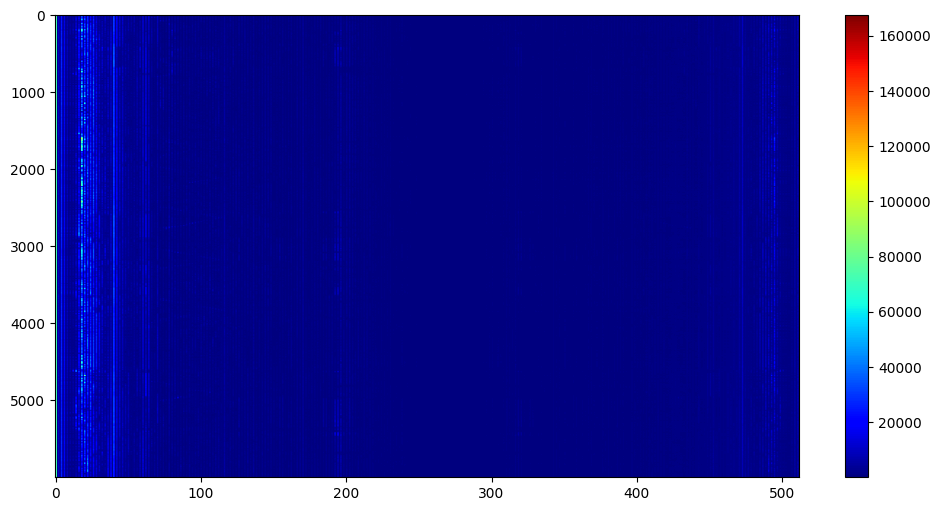

In [50]:
chirps_range_profiles = [np.fft.fft(chirp) for chirp in first_chirps_of_frame]
chirp_magnitudes = [np.abs(range_profile) for range_profile in chirps_range_profiles]

plt.figure(figsize=(12, 6))
plt.imshow(chirp_magnitudes,aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

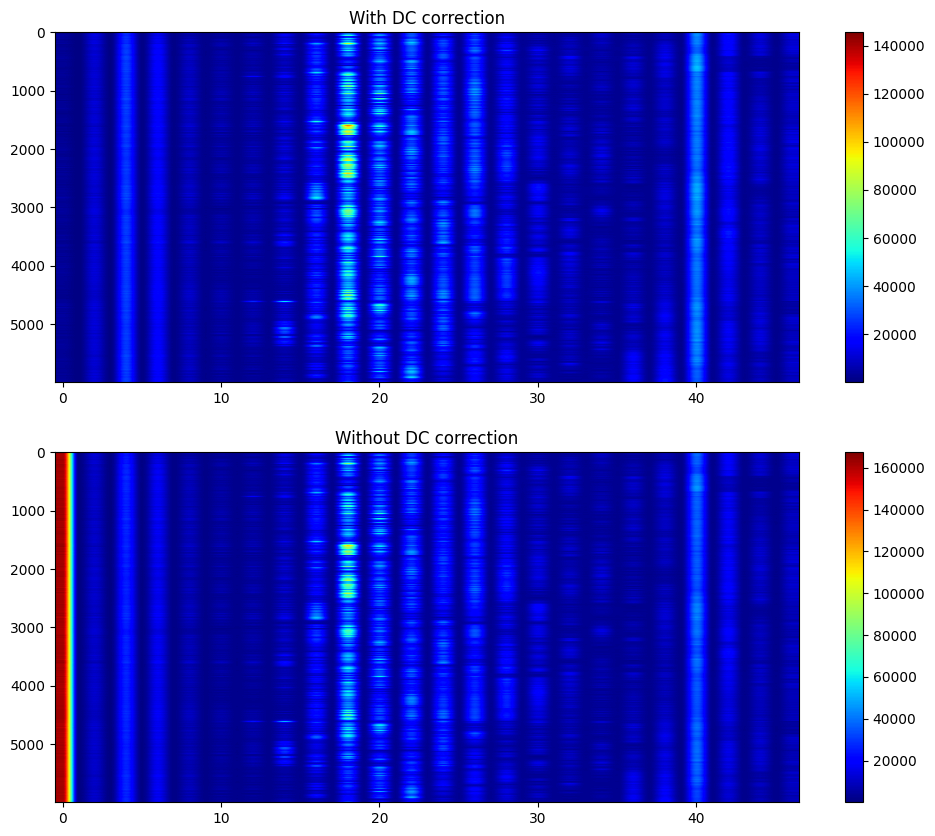

In [51]:
DC_corrected_chirps_range_profile = [np.fft.fft(DC_corrected_chirp) for DC_corrected_chirp in DC_corrected_chirps]
DC_corrected_magnitude = [np.abs(DC_corrected_chirps_fft) for DC_corrected_chirps_fft in DC_corrected_chirps_range_profile]


fft_chirps =[np.fft.fft(chirp) for chirp in first_chirps_of_frame]
abs_chirps =[np.abs(np.fft.fft(chirp)) for chirp in first_chirps_of_frame]



# for tmp_dc  in DC_corrected_magnitude:
#     tmp_dc[0]=140000
#     tmp_dc[2]=140000
#     tmp_dc[4]=140000
#     tmp_dc[6]=140000
#     tmp_dc[8]=140000
#     tmp_dc[12]=140000
#     tmp_dc[14]=140000
#     tmp_dc[16]=140000
#     tmp_dc[20]=140000


plt.figure(figsize=(12, 10))

plt.subplot(211)

plt.imshow(np.array(DC_corrected_magnitude)[:,0:47],aspect='auto',cmap='jet')
plt.title("With DC correction")
plt.colorbar()

plt.subplot(212)

plt.imshow(np.array(abs_chirps)[:,0:47],cmap='jet',aspect='auto')
plt.title("Without DC correction")
plt.colorbar()

plt.show()

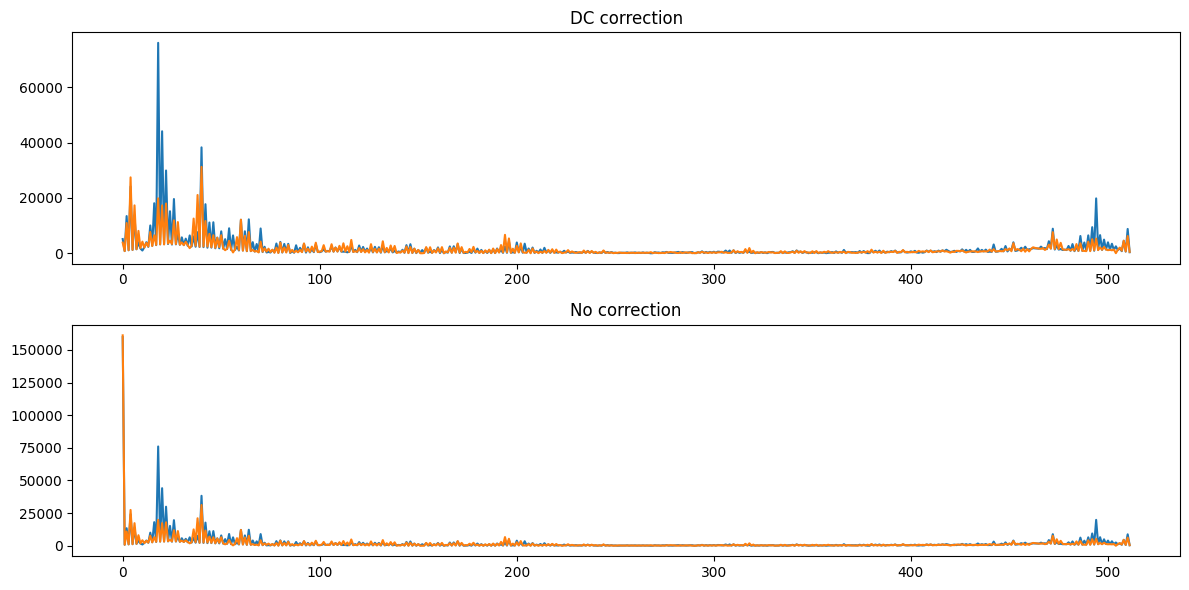

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(DC_corrected_magnitude[0])
plt.plot(DC_corrected_magnitude[-1])
plt.title("DC correction")

plt.subplot(2,1,2)
plt.plot(chirp_magnitudes[0])
plt.plot(chirp_magnitudes[-1])
plt.title("No correction")
plt.tight_layout()
plt.show()

(200,)


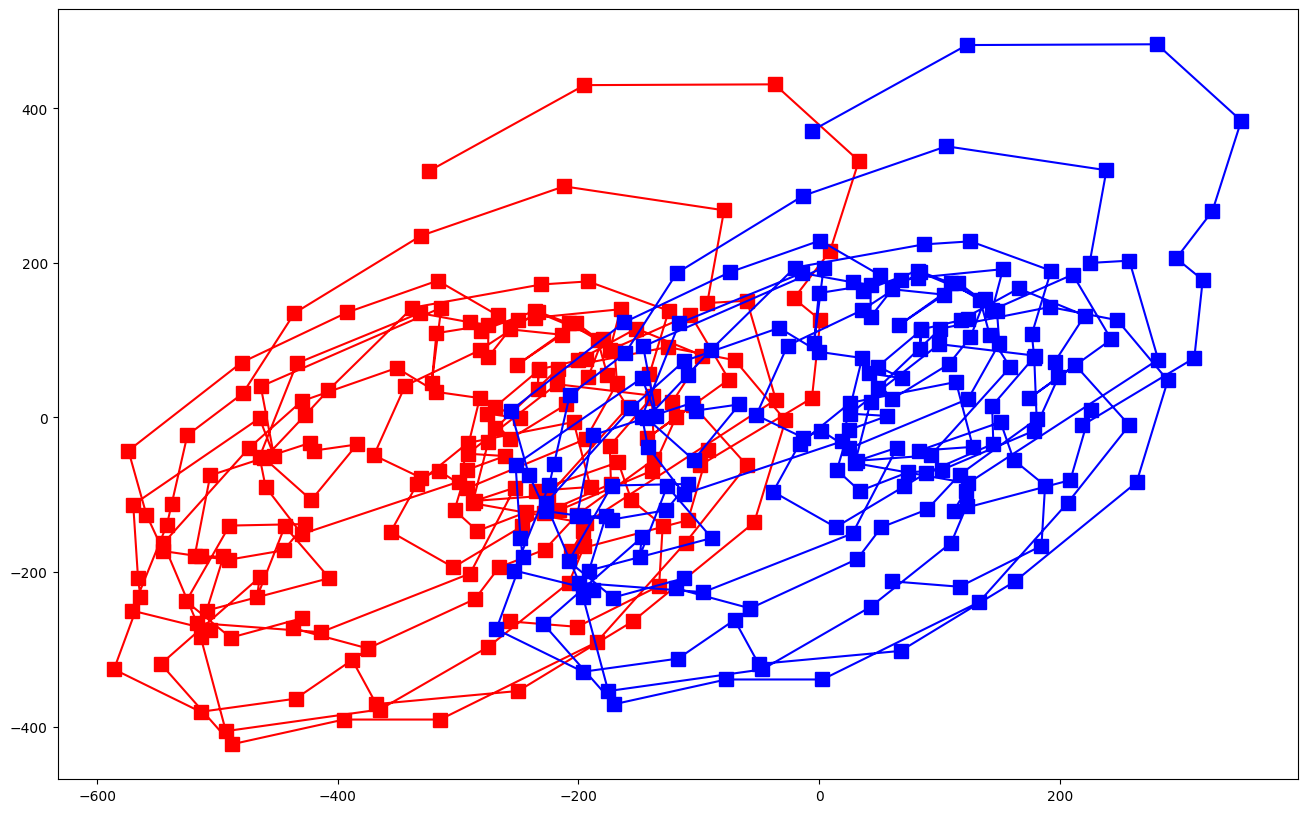

In [53]:

raw_chirps = (np.array(first_chirps_of_frame).flatten())[0:200]
raw_chirps_real = [raw_chirp.real for raw_chirp in raw_chirps]
raw_chirps_image = [raw_chirp.imag for raw_chirp in raw_chirps]

print( np.array(raw_chirps_real).shape)

dc_chirps  =(np.array(DC_corrected_chirps).flatten()) [0:200]
DC_corrected_real = [dc_chirp.real for dc_chirp in dc_chirps]
DC_corrected_image =[dc_chirp.imag for dc_chirp in dc_chirps]

plt.figure(figsize=(16, 10))

plt.plot(raw_chirps_real, raw_chirps_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(raw_chirps_real, raw_chirps_image, color='red')

plt.plot(DC_corrected_real, DC_corrected_image, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real, DC_corrected_image, color='blue')

plt.show()


In [54]:
magnitude_index = np.zeros(shape=len(DC_corrected_magnitude))
for  magnitude_spectrum in DC_corrected_magnitude:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[0:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)

index: 14  :  38.0
index: 16  :  153.0
index: 18  :  2731.0
index: 20  :  837.0
index: 22  :  502.0
index: 24  :  186.0
index: 26  :  53.0
index: 40  :  1500.0
bin of interest:  [18]


In [55]:

interested_bin_phase =np.array(DC_corrected_chirps)[:,bin_of_interest]
interested_bin_angle =np.unwrap(np.angle(interested_bin_phase))

windowed_signal = interested_bin_angle.flatten() * np.hanning(len(interested_bin_angle))
hamming_windowed_signal = interested_bin_angle.flatten() * np.hamming(len(interested_bin_angle))



In [56]:
# try to apply DACM on interested_bin_phase
#I :real
#Q :imagine
phase_len =len(interested_bin_phase)


phase_k = np.zeros(shape=(np.array(interested_bin_phase).shape),dtype=float)
phase_k[0]=np.angle(interested_bin_phase[0])
phase_k[1]=np.angle(interested_bin_phase[1])
for i in range(2,phase_len):
    I_k=interested_bin_phase[i].real
    Q_k=interested_bin_phase[i].imag

    I_k_1=interested_bin_phase[i-1].real
    Q_k_1=interested_bin_phase[i-1].imag
    
    phase_k[i]+= (I_k * (Q_k -Q_k_1) -(I_k - I_k_1)* Q_k)/(I_k*I_k + Q_k * Q_k)
    

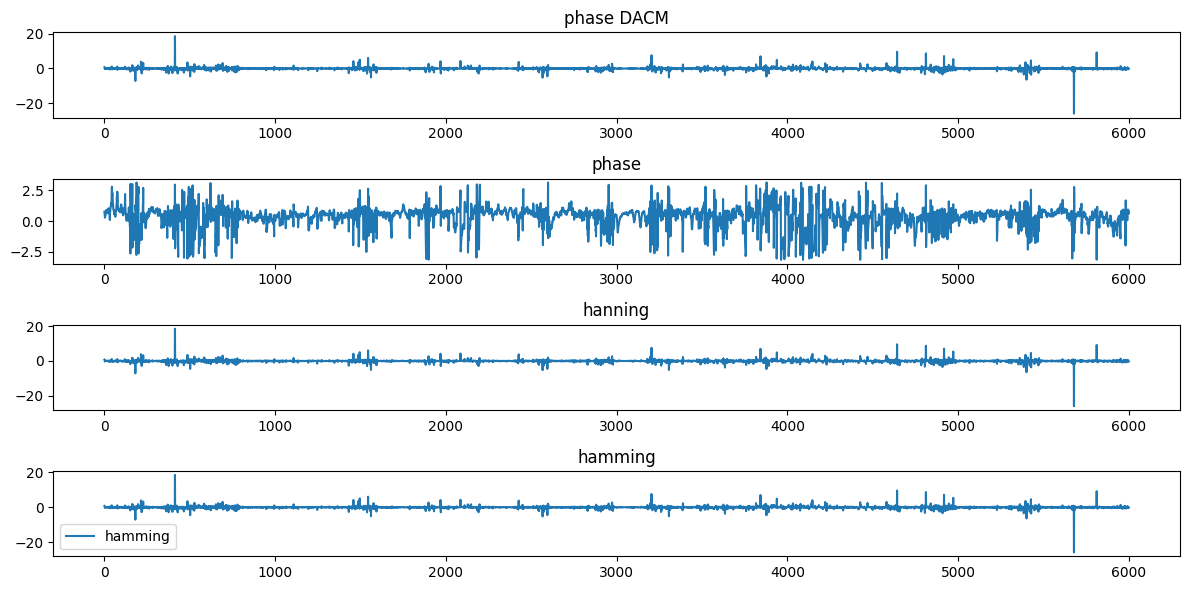

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(phase_k,label='phase DACM')
plt.title("phase DACM")

plt.subplot(4,1,2)
plt.plot(interested_bin_angle,label='phase')
plt.title("phase")


windowed_signal_phase_k_hanning = phase_k.flatten() 
plt.subplot(4,1,3)
plt.plot(windowed_signal_phase_k_hanning,label='hanning')
plt.title("hanning")


windowed_signal_phase_k_hamming = phase_k.flatten() 
plt.subplot(4,1,4)
plt.plot(windowed_signal_phase_k_hamming,label='hamming')
plt.title("hamming")


plt.tight_layout()
plt.legend()
plt.show()

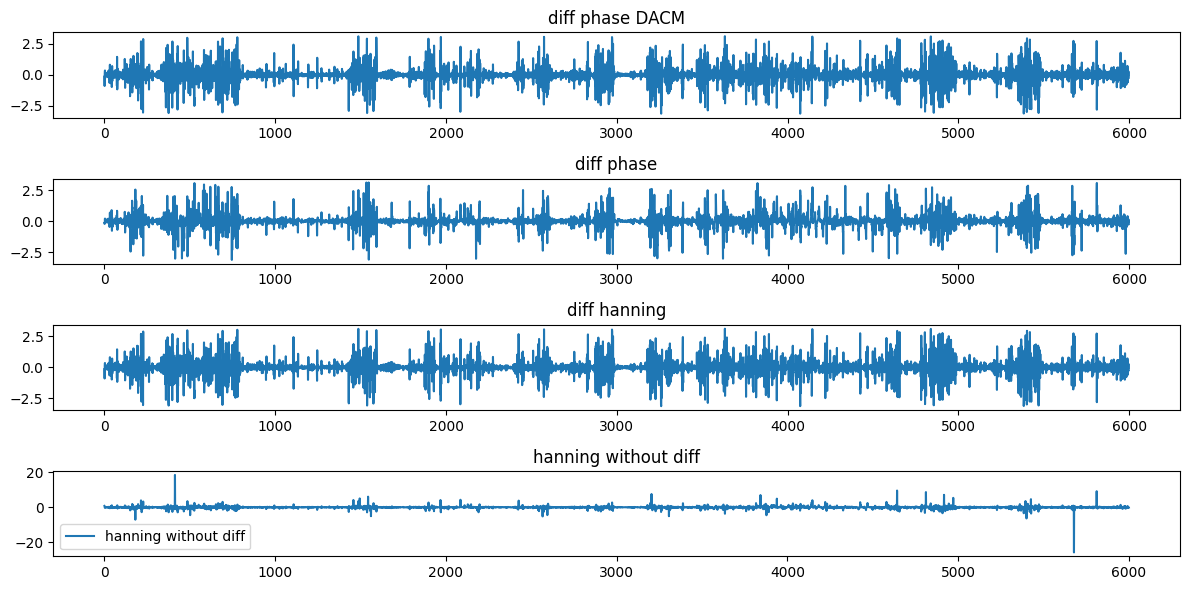

In [58]:
#perform differntial phase

diff_phase_k =np.diff(np.unwrap(np.array(phase_k).flatten()))

diff_interested_bin_angle =np.diff(np.unwrap(np.array(interested_bin_angle).flatten()))
diff_windowed_signal_phase_k_hanning =np.diff(np.unwrap(windowed_signal_phase_k_hanning))
diff_windowed_signal_phase_k_hamming =np.diff(np.unwrap(windowed_signal_phase_k_hamming))

plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(diff_phase_k,label='phase DACM')
plt.title("diff phase DACM")

plt.subplot(4,1,2)
plt.plot(diff_interested_bin_angle,label='phase')
plt.title("diff phase")



plt.subplot(4,1,3)
plt.plot(diff_windowed_signal_phase_k_hanning,label='hanning')
plt.title("diff hanning")



plt.subplot(4,1,4)
plt.plot(windowed_signal_phase_k_hanning,label='hanning without diff')
plt.title("hanning without diff")


plt.tight_layout()
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


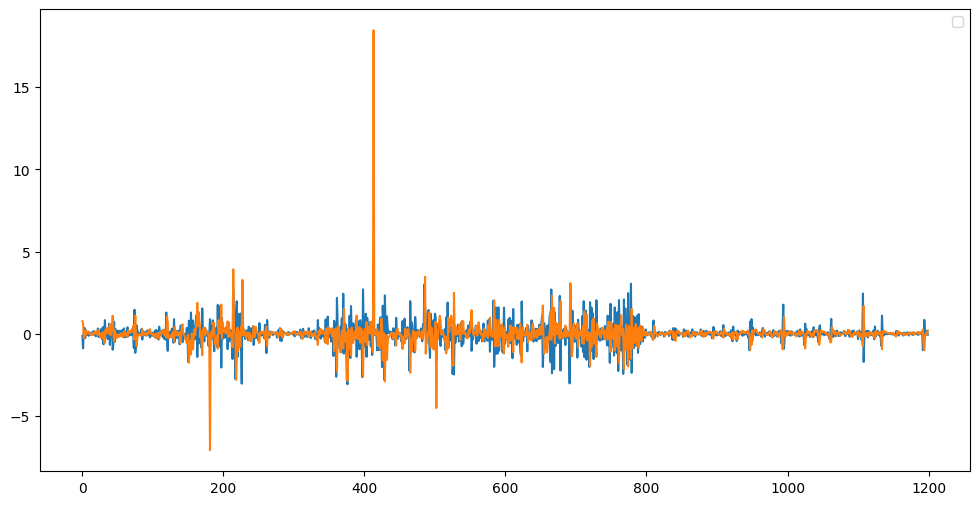

In [59]:

plt.figure(figsize=(12,6))
plt.plot(diff_windowed_signal_phase_k_hamming[0:1200])
plt.plot(windowed_signal_phase_k_hanning[0:1200])

plt.legend()
plt.show()

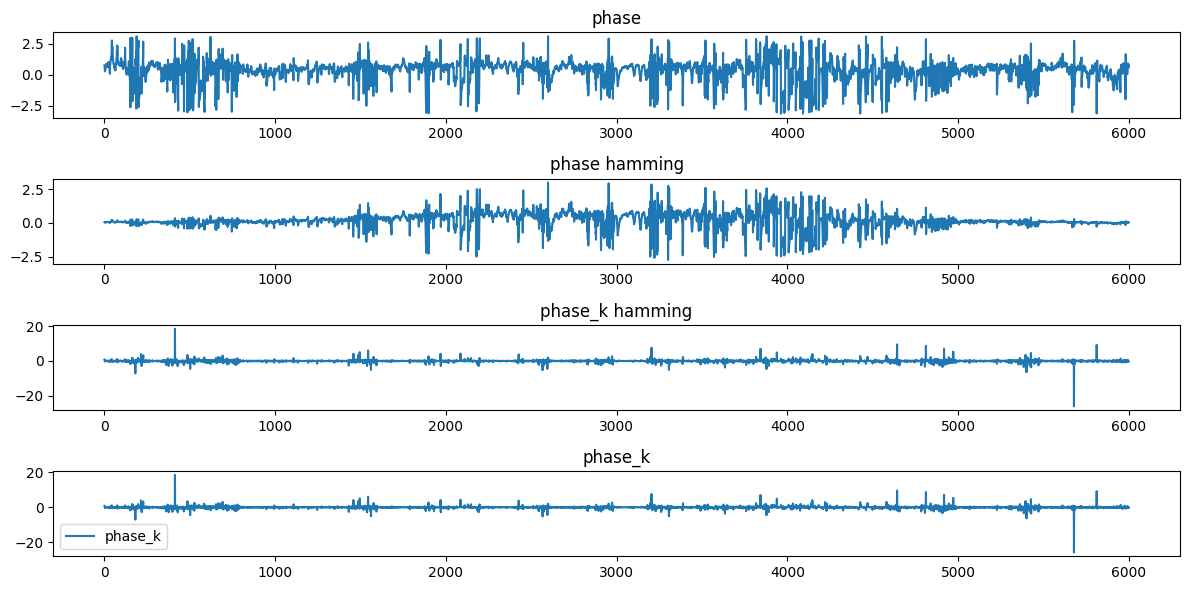

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(interested_bin_angle,label='phase')
plt.title("phase")
plt.subplot(412)
plt.plot(hamming_windowed_signal,label='phase with hamming')
plt.title("phase hamming")
plt.subplot(413)
plt.plot(windowed_signal_phase_k_hamming,label='phase_k with hamming')
plt.title("phase_k hamming")
plt.subplot(414)
plt.plot(phase_k,label='phase_k')
plt.title("phase_k")
plt.tight_layout()
plt.legend()

plt.show()

In [ ]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = signal.lfilter(b, a, signal_to_filter)
    return signal_filtered

phase_k_filtered_diff =filter_signal(diff_phase_k,0.1,0.5,1200,4)



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns

axes[0].set_title("phase k")
axes[0].plot(phase_k_filtered_diff,label ='phase_k')

axes[1].plot(np.fft.fft(phase_k_filtered_diff))
axes[1].set_title("phase k spectrum")
plt.show()





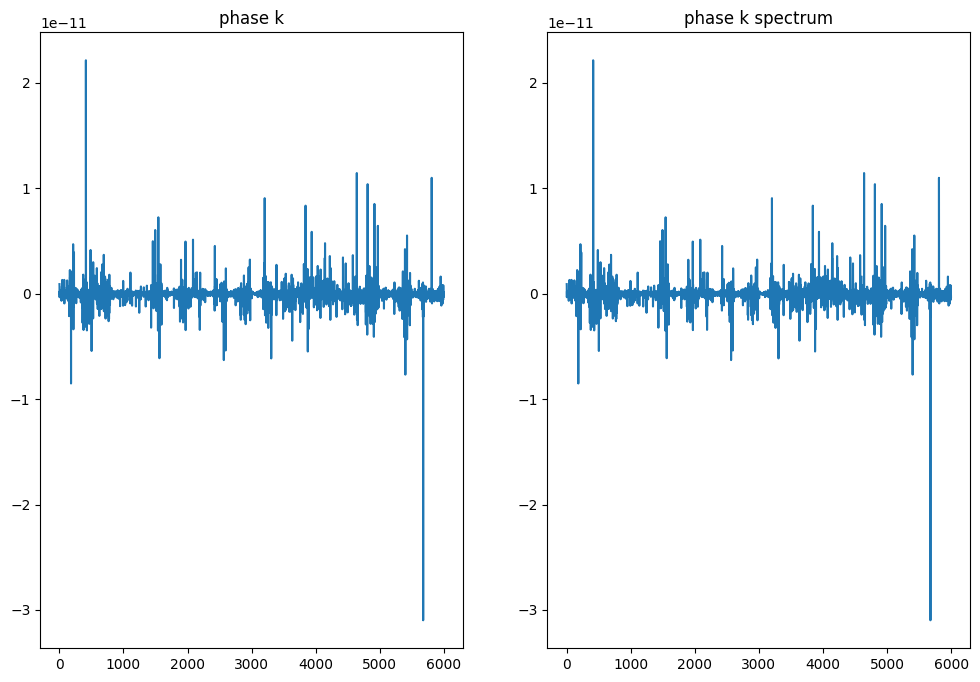

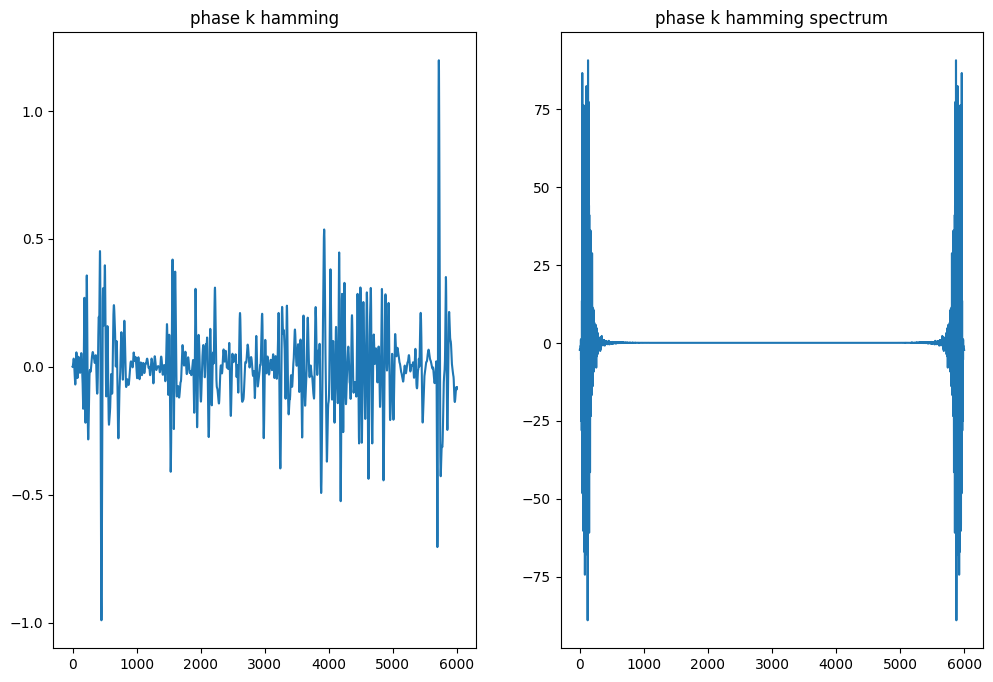

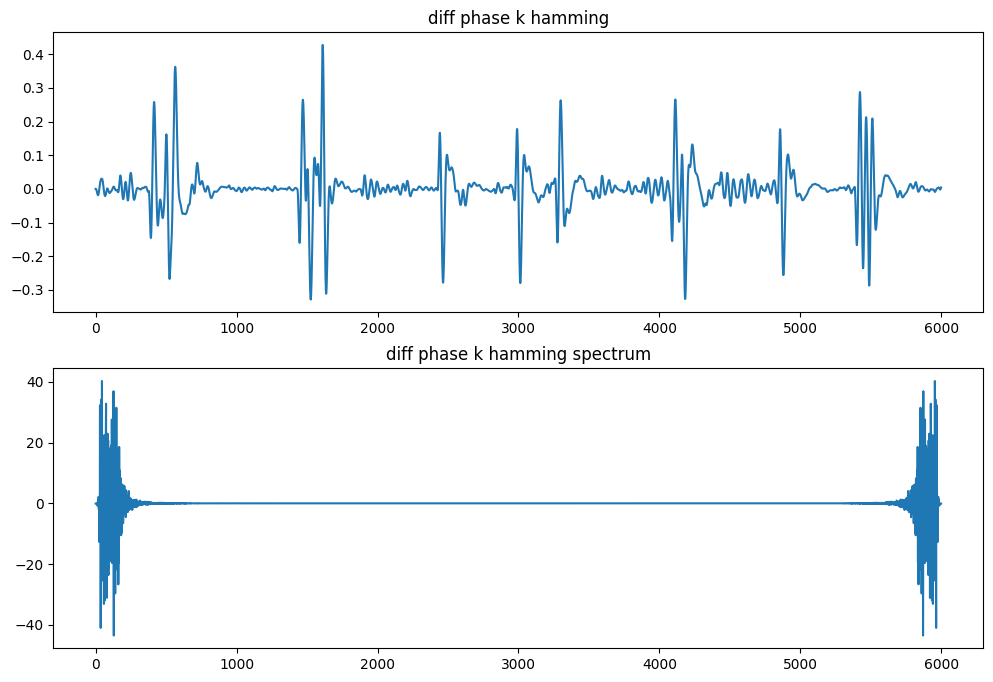

(array([[5.79420658e-08, 1.74475520e-08, 4.51459077e-06, ...,
         9.57758001e-06, 1.11057028e-05, 2.22382419e-06],
        [1.52518529e-06, 4.71032929e-07, 3.82795638e-05, ...,
         4.15178591e-05, 7.44831136e-05, 1.62657352e-05],
        [4.76616281e-06, 2.42241953e-06, 1.77541087e-04, ...,
         8.30452891e-06, 6.90194944e-05, 1.26640414e-05],
        ...,
        [1.30472697e-19, 1.22704548e-18, 6.70752015e-18, ...,
         1.60400461e-20, 4.54852814e-18, 1.48256314e-20],
        [1.15645588e-19, 1.20453670e-18, 6.64252027e-18, ...,
         4.75217089e-21, 4.35818569e-18, 7.03695562e-21],
        [5.54428165e-20, 5.98621891e-19, 3.30991257e-18, ...,
         4.90885175e-22, 2.14744345e-18, 2.22423202e-21]]),
 array([  0.    ,   4.6875,   9.375 ,  14.0625,  18.75  ,  23.4375,
         28.125 ,  32.8125,  37.5   ,  42.1875,  46.875 ,  51.5625,
         56.25  ,  60.9375,  65.625 ,  70.3125,  75.    ,  79.6875,
         84.375 ,  89.0625,  93.75  ,  98.4375, 103.125 , 107

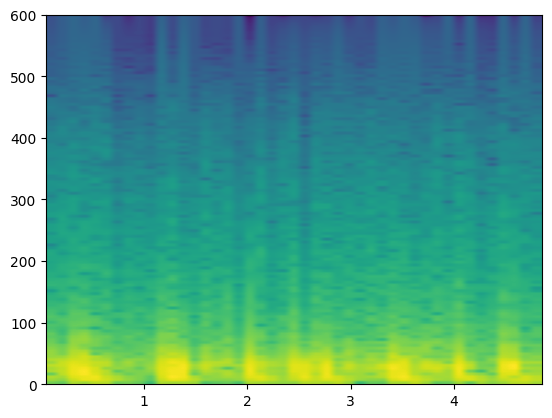

In [61]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = signal.lfilter(b, a, signal_to_filter)
    return signal_filtered

phase_k_filtered =filter_signal(phase_k,0.1,0.5,1200,4)
windowed_signal_phase_k_hanning_filtered =filter_signal(windowed_signal_phase_k_hanning,0.1,0.5,1200/60,4)
diff_windowed_signal_phase_k_hanning_filtered =filter_signal(diff_windowed_signal_phase_k_hanning,0.1,0.5,1200/60,4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns

axes[0].set_title("phase k")
axes[0].plot(phase_k_filtered,label ='phase_k')

axes[1].plot(np.fft.fft(phase_k_filtered))
axes[1].set_title("phase k spectrum")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(windowed_signal_phase_k_hanning_filtered,label ='phase_k hamming')
axes[0].set_title("phase k hamming")

axes[1].plot(np.fft.fft(windowed_signal_phase_k_hanning_filtered),label ='phase_k hamming')
axes[1].set_title("phase k hamming spectrum")
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))  # 1 row, 2 columns

axes[0].plot(diff_windowed_signal_phase_k_hanning_filtered,label ='phase_k diff')
axes[0].set_title("diff phase k hamming")

axes[1].plot(np.fft.fft(diff_windowed_signal_phase_k_hanning_filtered),label ='phase_k diff')
axes[1].set_title("diff phase k hamming spectrum")

plt.show()


plt.specgram(diff_windowed_signal_phase_k_hanning_filtered, Fs=1200)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


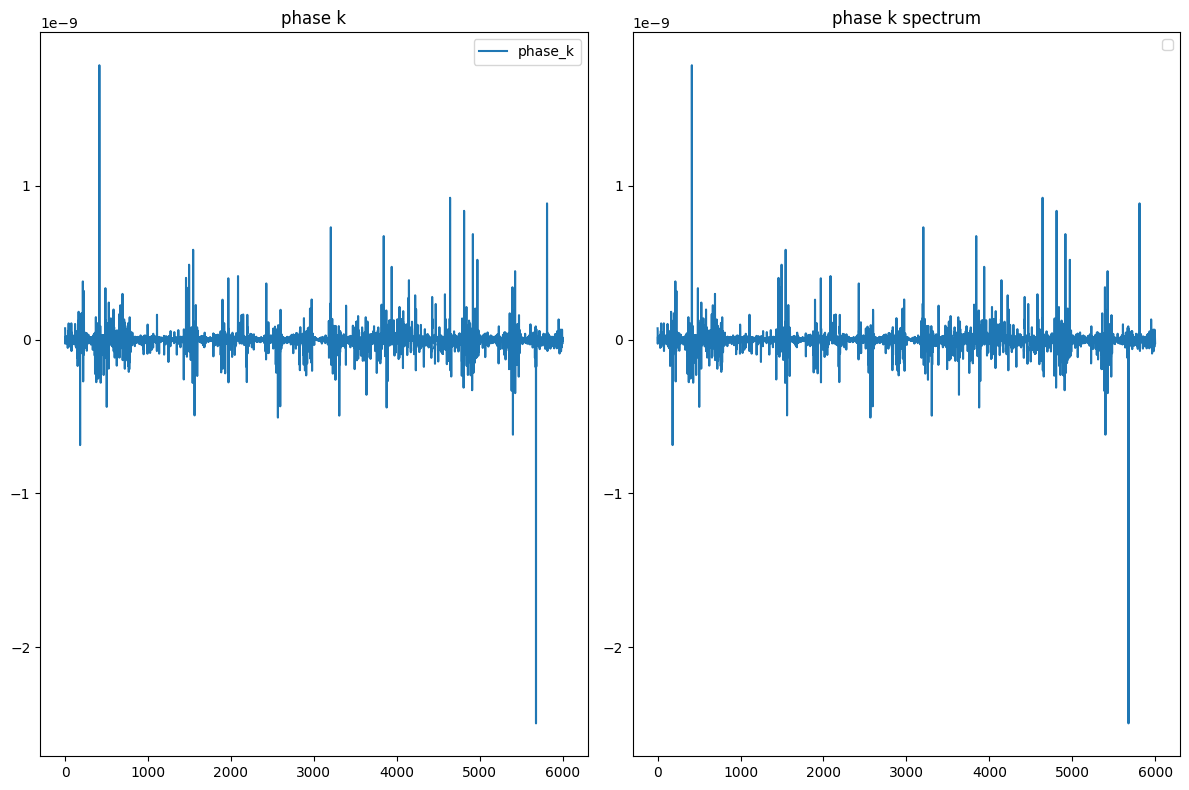

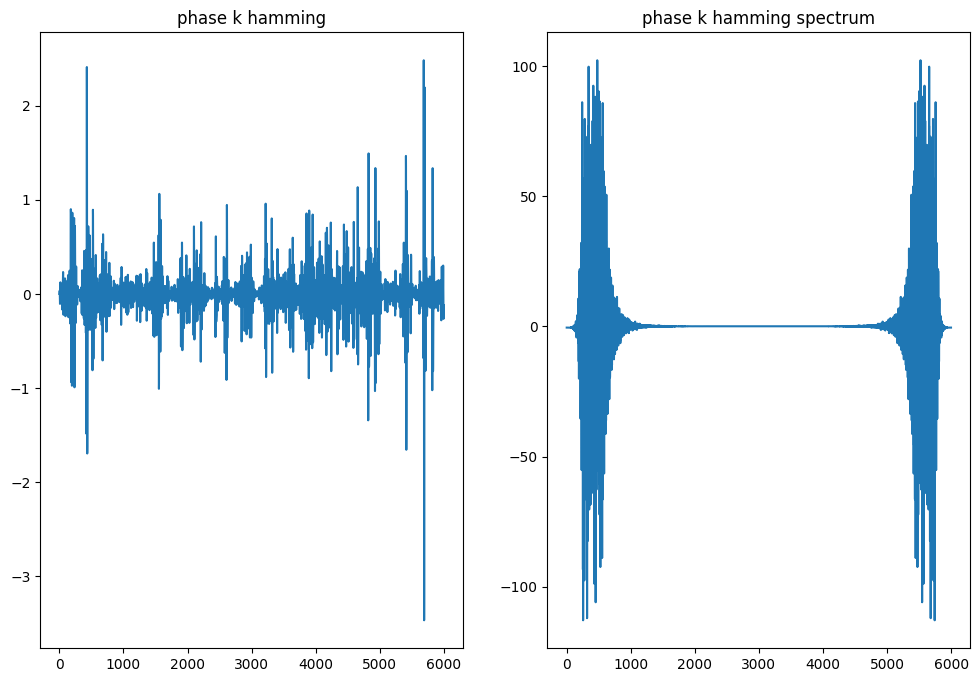

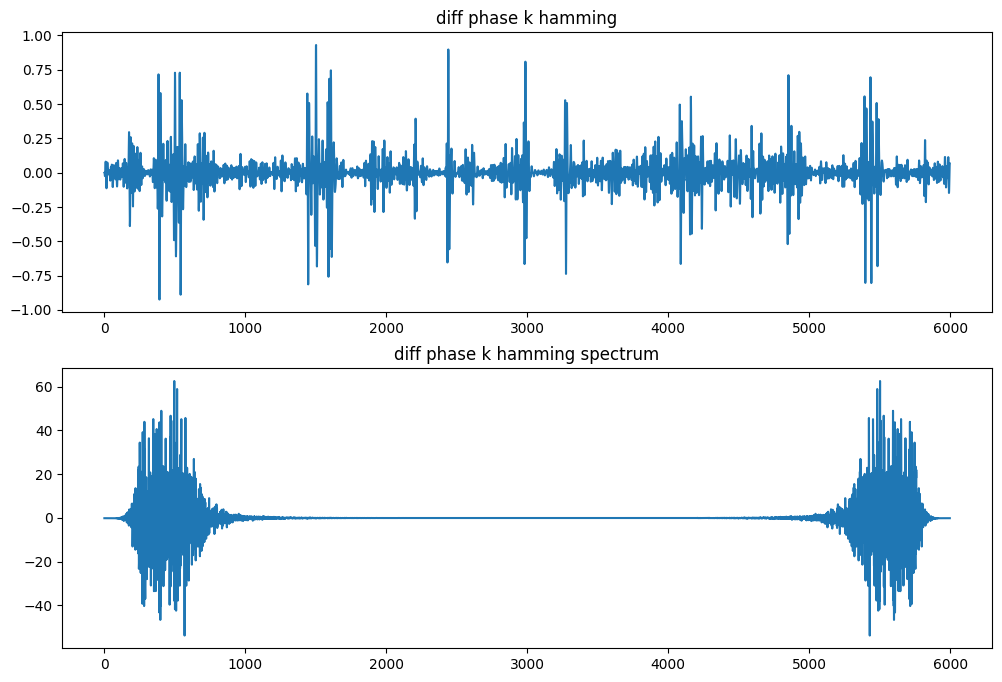

(array([[2.64860102e-12, 1.83203870e-11, 4.88131465e-12, ...,
         1.12243618e-11, 3.87370396e-11, 3.83097264e-14],
        [6.14899502e-12, 3.68246760e-11, 5.46162506e-11, ...,
         2.37834190e-11, 9.13319855e-11, 1.97804189e-13],
        [4.20497721e-12, 2.04569645e-11, 3.49439106e-10, ...,
         1.19603156e-10, 1.42217780e-10, 4.38731254e-14],
        ...,
        [1.85796310e-17, 6.53409742e-16, 2.28943758e-16, ...,
         2.52104727e-17, 9.82559790e-18, 2.09606945e-17],
        [1.86694194e-17, 6.45973300e-16, 2.27980726e-16, ...,
         2.44100573e-17, 9.42238835e-18, 2.09807608e-17],
        [9.23881705e-18, 3.21511394e-16, 1.14158343e-16, ...,
         1.21713151e-17, 4.64031196e-18, 1.04908389e-17]]),
 array([  0.    ,   4.6875,   9.375 ,  14.0625,  18.75  ,  23.4375,
         28.125 ,  32.8125,  37.5   ,  42.1875,  46.875 ,  51.5625,
         56.25  ,  60.9375,  65.625 ,  70.3125,  75.    ,  79.6875,
         84.375 ,  89.0625,  93.75  ,  98.4375, 103.125 , 107

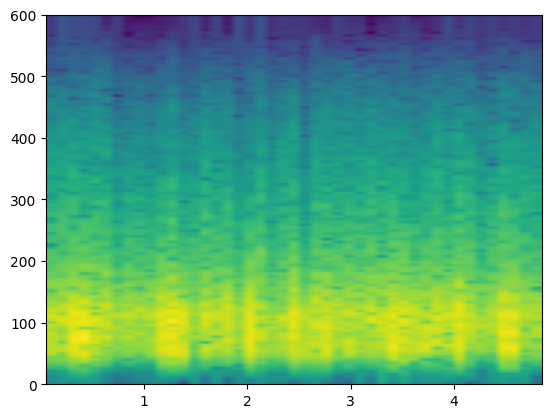

In [62]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = signal.lfilter(b, a, signal_to_filter)
    return signal_filtered

heart_phase_k_filtered =filter_signal(phase_k,0.8,2,1200,4)
heart_windowed_signal_phase_k_hanning_filtered =filter_signal(windowed_signal_phase_k_hanning,0.8,2,1200/60,4)
heart_diff_windowed_signal_phase_k_hanning_filtered =filter_signal(diff_windowed_signal_phase_k_hanning,0.8,2,1200/60,4)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].set_title("phase k")
axes[0].plot(heart_phase_k_filtered,label ='phase_k')
axes[0].legend()
axes[1].plot(np.fft.fft(heart_phase_k_filtered))
axes[1].set_title("phase k spectrum")
axes[1].legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(heart_windowed_signal_phase_k_hanning_filtered,label ='phase_k hamming')
axes[0].set_title("phase k hamming")

axes[1].plot(np.fft.fft(heart_windowed_signal_phase_k_hanning_filtered),label ='phase_k hamming')
axes[1].set_title("phase k hamming spectrum")
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(heart_diff_windowed_signal_phase_k_hanning_filtered,label ='phase_k diff')
axes[0].set_title("diff phase k hamming")
axes[1].plot(np.fft.fft(heart_diff_windowed_signal_phase_k_hanning_filtered),label ='phase_k diff')
axes[1].set_title("diff phase k hamming spectrum")

plt.show()

plt.specgram(heart_diff_windowed_signal_phase_k_hanning_filtered, Fs=1200)


In [63]:
wavelet = 'db5'
level = 6

# Perform the DWT
coeffs = pywt.wavedec(diff_windowed_signal_phase_k_hanning, wavelet, level=level)

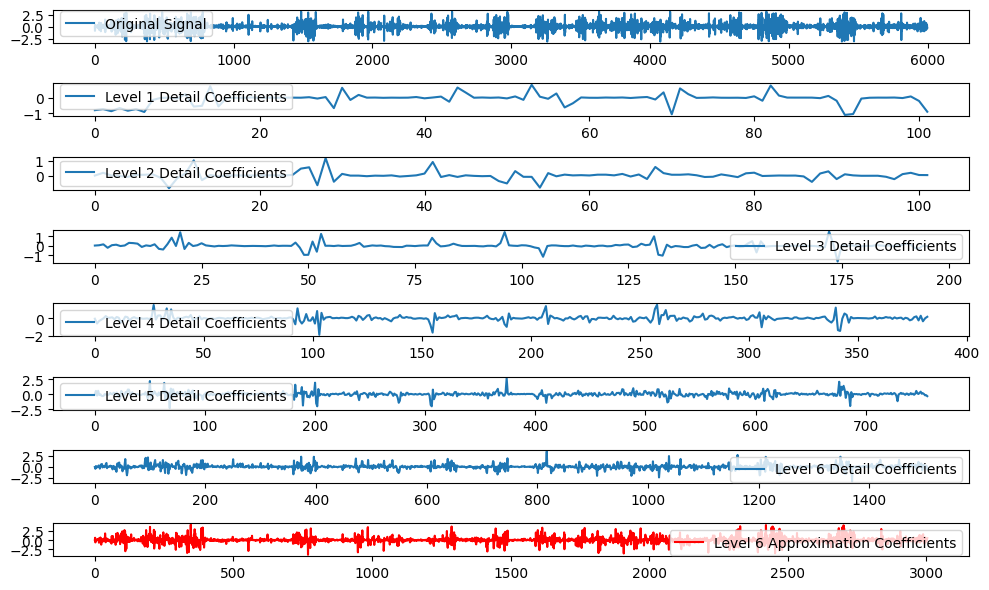

In [64]:
plt.figure(figsize=(10, 6))

plt.subplot(level + 2, 1, 1)
plt.plot(diff_windowed_signal_phase_k_hanning, label='Original Signal')
plt.legend()

for i in range(1, level + 1):
    plt.subplot(level + 2, 1, i + 1)
    plt.plot(coeffs[i - 1], label=f'Level {i} Detail Coefficients')
    plt.legend()

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[level], label=f'Level {level} Approximation Coefficients', color='red')
plt.legend()

plt.tight_layout()
plt.show()

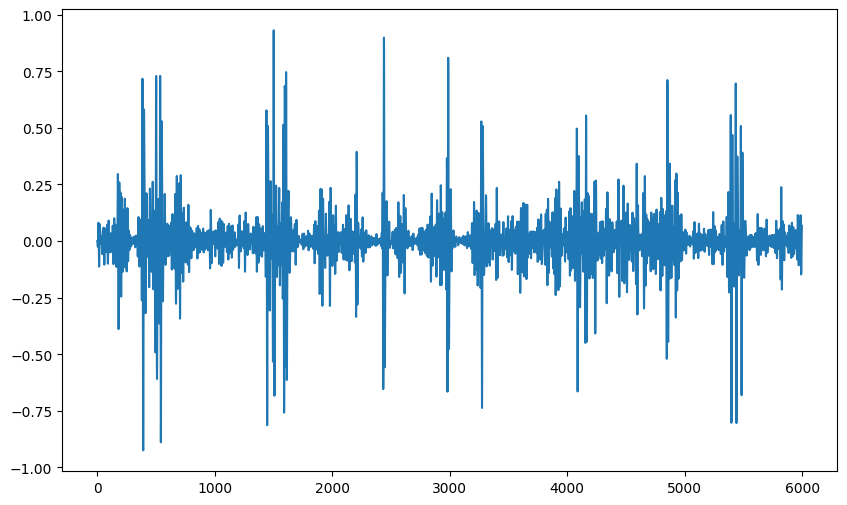

<Figure size 1000x600 with 0 Axes>

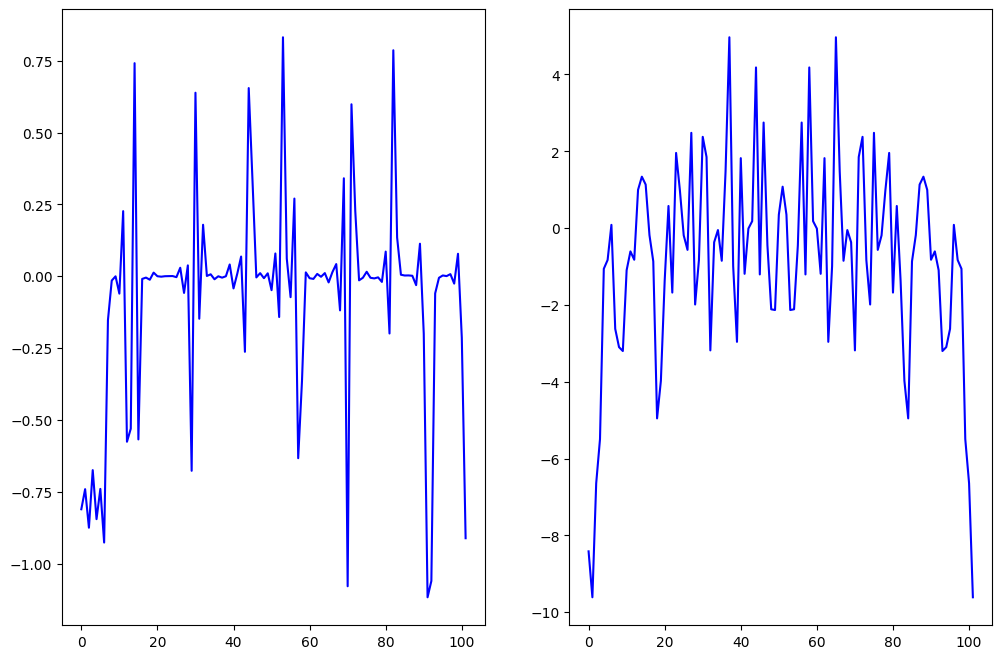

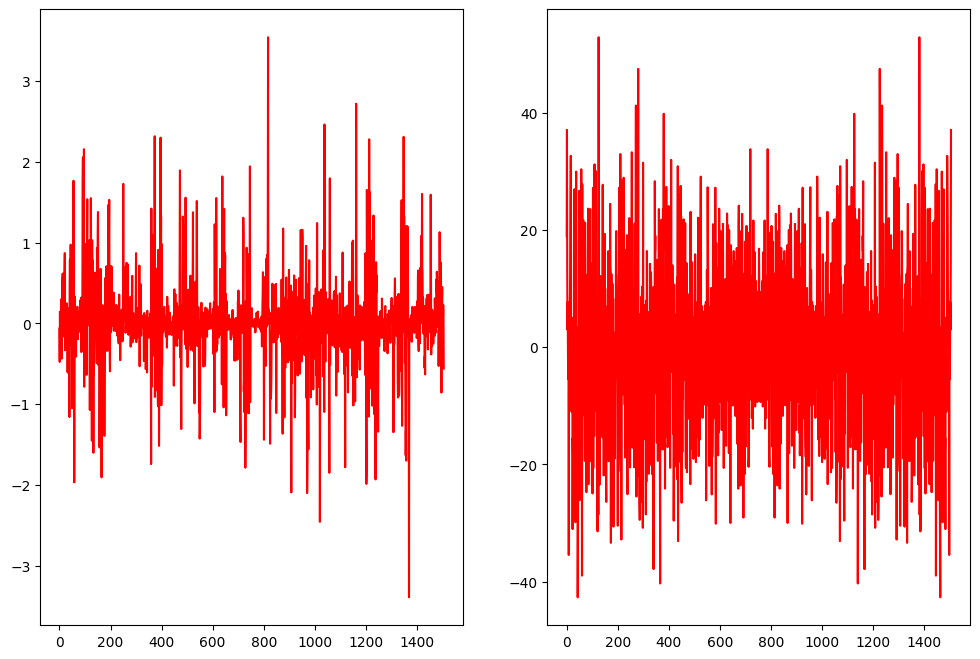

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(heart_diff_windowed_signal_phase_k_hanning_filtered, label='Original Signal')

plt.show()

plt.figure(figsize=(10, 6))

approximation_6 = coeffs[0]
detail_6 = coeffs[6 - 1]  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(approximation_6, label=f'Level {level} Breath', color='blue')
axes[1].plot(np.fft.fft(approximation_6), label=f'Level {level} Breath', color='blue')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))  # 1 row, 2 columns
axes[0].plot(detail_6, label=f'Level {level} Heart', color='red')
axes[1].plot(np.fft.fft(detail_6), label=f'Level {level} Heart', color='red')
plt.show()


